In [1]:
import pandas as pd
import itertools
from itertools import chain
from collections import Counter
from matplotlib import pyplot as plt

In [9]:
mon = pd.read_csv('AIES-2022-lightning-monday.csv')
tues = pd.read_csv('AIES-2022-lightning-tuesday.csv')
student = pd.read_csv('AIES-2022-student-lightning.csv')

In [10]:
mon_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(mon.loc[:,mon.columns[2:]].values.tolist())))
tues_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(tues.loc[:,tues.columns[2:]].values.tolist())))
student_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(student.loc[:,student.columns[2:]].values.tolist())))

In [5]:
print(len(mon_inst))
print(len(tues_inst))
print(len(student_inst))

44
41
35


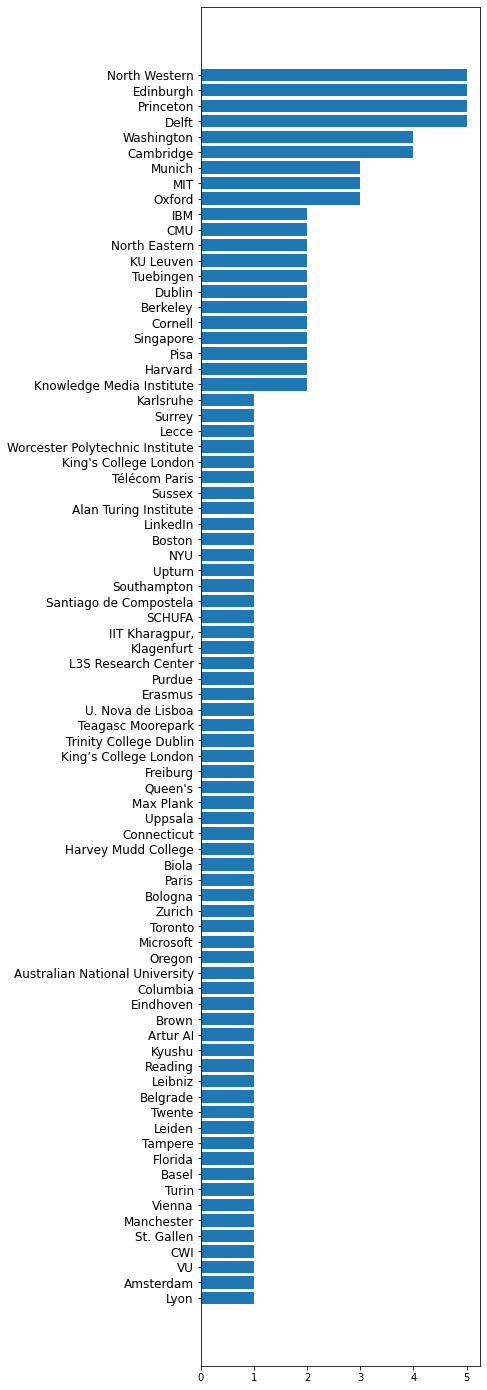

In [11]:
all_lgn = mon_inst + tues_inst + student_inst
orgs, cnts = zip(*Counter(all_lgn).most_common())
plt.figure(figsize=(5, 25))
plt.yticks(fontsize=12)
plt.barh(orgs, cnts)
plt.gca().invert_yaxis()

